<a href="https://colab.research.google.com/github/149189/Experiments_on_Food101_dataset/blob/main/Model_0_on_Food_101_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
import zipfile
import os
from pathlib import Path

In [ ]:
def unzip_data(zip_path, extract_to="."):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir = Path("10_food_classes_10_percent/train")
test_dir = Path("10_food_classes_10_percent/test")

--2024-08-16 14:12:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   163MB/s    in 1.0s    

2024-08-16 14:12:37 (163 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # This ensures labels are one-hot encoded
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
import tensorflow as tf

# Function to load images and preprocess them
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image

# Function to get the dataset from directory
def get_dataset_from_directory(directory, batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        shuffle=True,
        batch_size=batch_size,
        image_size=(224, 224)
    )
    # Convert labels to one-hot encoding
    dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, depth=10)))
    return dataset

train_data_10_percent = get_dataset_from_directory(train_dir)
test_data = get_dataset_from_directory(test_dir)

# Prefetch to improve performance
train_data_10_percent = train_data_10_percent.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
input_shape = (224, 224, 3)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model = models.Model(inputs, outputs)

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)


Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 805ms/step - accuracy: 0.2345 - loss: 2.1719 - val_accuracy: 0.6875 - val_loss: 1.4106
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7292 - loss: 1.2539 - val_accuracy: 0.7928 - val_loss: 0.9287
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7880 - loss: 0.9084 - val_accuracy: 0.7993 - val_loss: 0.8048
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8346 - loss: 0.7272 - val_accuracy: 0.8174 - val_loss: 0.7196
Epoch 5/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8462 - loss: 0.6396

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8474 - loss: 0.6380 - val_accuracy: 0.7794 - val_loss: 0.7010


In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8268 - loss: 0.6472


[0.64954674243927, 0.8276000022888184]

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-16 14:17:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-16 14:17:25 (39.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


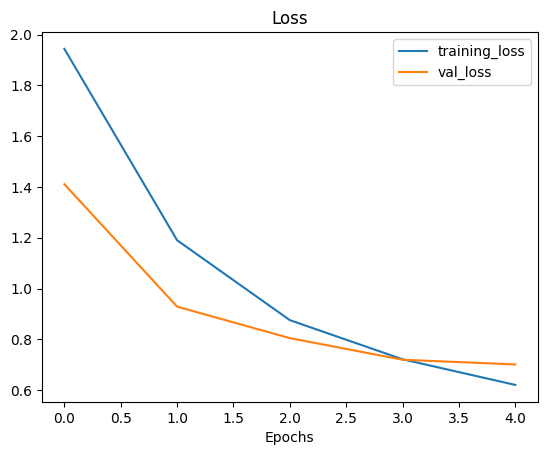

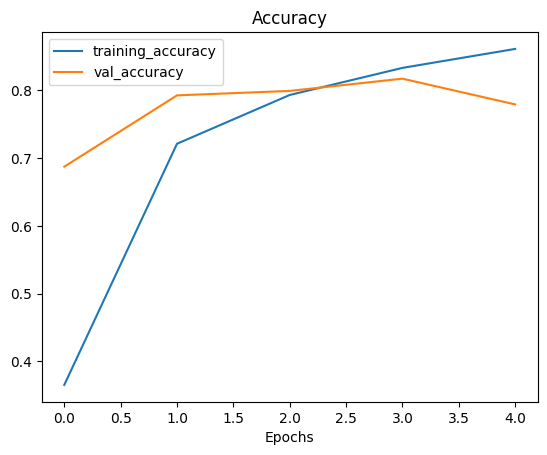

In [ ]:
plot_loss_curves(history)